# K Nearest Neighbors Classifier

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../../FeatureEngineering/MetaData/data6_&_odds.csv')
df.dropna(inplace=True)

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = df.loc[(df.season <= 2013) & (df.season >= 2007)]
valid_data = df.loc[(df.season > 2013) & (df.season < 2016)]
test_data = df.loc[df.season >= 2016]
full_train_data = pd.concat([train_data, valid_data], axis=0)

X_train, y_train = train_data.drop(columns=["game_date_est","season","game_id","home_team","visitor_team","home_team_id","visitor_team_id","home_team_wins","conference","conference_visitor"]), train_data.home_team_wins
X_val, y_val = valid_data.drop(columns=["game_date_est","season","game_id","home_team","visitor_team","home_team_id","visitor_team_id","home_team_wins","conference","conference_visitor"]), valid_data.home_team_wins
X_test, y_test = test_data.drop(columns=["game_date_est","season","game_id","home_team","visitor_team","home_team_id","visitor_team_id","home_team_wins","conference","conference_visitor"]), test_data.home_team_wins


## KNN with GridSearchCV and PCA

In [52]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
# Choose number of components = 30 based on a feature selection coding process we already executed
n_components = 30

pca = PCA(n_components=n_components).fit(X_train)
trainPCA = pca.transform(X_train)
valPCA = pca.transform(X_val)
testPCA = pca.transform(X_test)

In [63]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(trainPCA, y_train)
val_score = estimator.score(valPCA, y_val)

preds = estimator.predict(testPCA)
test_score = estimator.score(testPCA, y_test)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 35.755372285842896 seconds
              precision    recall  f1-score   support

   home_loss       0.56      0.51      0.53      1935
    home_win       0.66      0.71      0.69      2648

    accuracy                           0.62      4583
   macro avg       0.61      0.61      0.61      4583
weighted avg       0.62      0.62      0.62      4583

val score: 0.6528925619834711
KNeighborsClassifier(leaf_size=1, n_neighbors=14)
{'leaf_size': 1, 'n_neighbors': 14}
best score: 0.6584057971014492
test score 0.6242635828060222


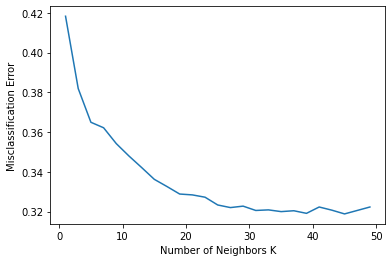

In [64]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, trainPCA, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [65]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(trainPCA, y_train)
pred = knn.predict(testPCA)
print("\nOptimal accuracy on the test set is", accuracy_score(y_test, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 45

Optimal accuracy on the test set is 0.6484835260746236 with k= 45


## Use of StandardScaler

In [66]:
from sklearn.preprocessing import StandardScaler

# Scaling features
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_val_standard = scaler.transform(X_val)
X_test_standard = scaler.transform(X_test)

In [67]:
import time

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_standard, y_train)
val_score = estimator.score(X_val_standard, y_val)

preds = estimator.predict(X_test_standard)
test_score = estimator.score(X_test_standard, y_test)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 37.021156549453735 seconds
              precision    recall  f1-score   support

   home_loss       0.57      0.53      0.55      1935
    home_win       0.67      0.70      0.69      2648

    accuracy                           0.63      4583
   macro avg       0.62      0.62      0.62      4583
weighted avg       0.63      0.63      0.63      4583

val score: 0.6541322314049587
KNeighborsClassifier(leaf_size=1, n_neighbors=14)
{'leaf_size': 1, 'n_neighbors': 14}
best score: 0.6553623188405797
test score 0.6295003272965306


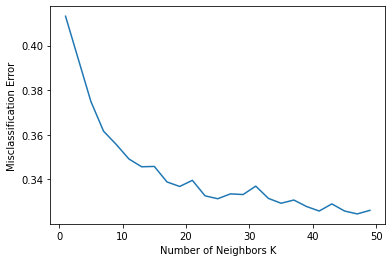

In [68]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_standard, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [69]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_standard, y_train)
pred = knn.predict(X_test_standard)
print("\nOptimal accuracy on the test set is", accuracy_score(y_test, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 47

Optimal accuracy on the test set is 0.6585206196814314 with k= 47


## kNN with ExtraTress Classifier

In [21]:
X_train_extra = train_data[['odds_home', 'odds_away', 'home_elo', 'visitor_elo', 'elo_diff',
                    'eff_diff', 'eff_visitor', 'top_player_diff', 'diff_win_pct_prev_season',
                    'diff_home_record_last_season', 'ROAD_RECORD_home',
                    'diff_road_record_last_season', 'diff_win_pct_7_last_games', 'W_PCT_home',
                    'W_PCT_away', 'W_PCT_prev_away', 'diff_curr_away_record', 'HOME_RECORD_home', 'diff_curr_home_record',
                    'diff_curr_win_pct']]
y_train_extra = y_train

X_val_extra = valid_data[['odds_home', 'odds_away', 'home_elo', 'visitor_elo', 'elo_diff',
                    'eff_diff', 'eff_visitor', 'top_player_diff', 'diff_win_pct_prev_season',
                    'diff_home_record_last_season', 'ROAD_RECORD_home',
                    'diff_road_record_last_season', 'diff_win_pct_7_last_games', 'W_PCT_home',
                    'W_PCT_away', 'W_PCT_prev_away', 'diff_curr_away_record', 'HOME_RECORD_home', 'diff_curr_home_record',
                    'diff_curr_win_pct']]

y_val_extra = y_val

X_test_extra = test_data[['odds_home', 'odds_away', 'home_elo', 'visitor_elo', 'elo_diff',
                    'eff_diff', 'eff_visitor', 'top_player_diff', 'diff_win_pct_prev_season',
                    'diff_home_record_last_season', 'ROAD_RECORD_home',
                    'diff_road_record_last_season', 'diff_win_pct_7_last_games', 'W_PCT_home',
                    'W_PCT_away', 'W_PCT_prev_away', 'diff_curr_away_record', 'HOME_RECORD_home', 'diff_curr_home_record',
                    'diff_curr_win_pct']]
y_test_extra = y_test

In [22]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_extra, y_train_extra)
val_score = estimator.score(X_val_extra, y_val_extra)

preds = estimator.predict(X_test_extra)
test_score = estimator.score(X_test_extra, y_test_extra)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test_extra, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 38.925517320632935 seconds
              precision    recall  f1-score   support

   home_loss       0.59      0.47      0.52      1935
    home_win       0.66      0.76      0.71      2648

    accuracy                           0.64      4583
   macro avg       0.63      0.62      0.62      4583
weighted avg       0.63      0.64      0.63      4583

val score: 0.6727272727272727
KNeighborsClassifier(leaf_size=1, n_neighbors=13)
{'leaf_size': 1, 'n_neighbors': 13}
best score: 0.6565217391304347
test score 0.6377918394065023


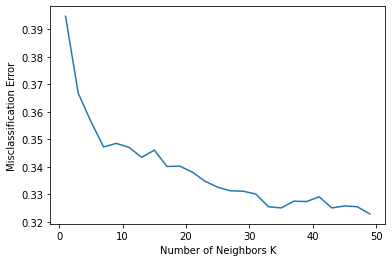

In [23]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_extra, y_train_extra, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [24]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_extra, y_train_extra)
pred = knn.predict(X_test_extra)
print("\nOptimal accuracy on the test set is", accuracy_score(y_test_extra, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6545930613135501 with k= 49


## kNN with RFE

In [25]:
X_train_rfe = train_data[['num_possible_outcomes', 'odds_home', 'odds_away', 'W_PCT_home',
            'HOME_RECORD_home', 'ROAD_RECORD_home', 'ROAD_RECORD_away',
            'WIN_PRCT_home_3g', 'PTS_home_3g', 'REB_home_3g', 'WIN_PRCT_away_3g',
            'AST_away_3g', 'REB_away_3g', 'PTS_home_7g', 'AST_home_7g',
            'REB_home_7g', 'AST_away_7g', 'diff_avg_pts_home', 'diff_avg_ast_home',
            'diff_avg_ast_away', 'diff_avg_fg3_pct_home', 'diff_avg_reb_home',
            'diff_avg_reb_away', 'top_players', 'eff_visitor', 'HG_7days',
            'AG_7days', 'G_7days', 'back2back', 'HG_7days_VISITOR',
            'G_7days_VISITOR', 'back2back_visitor', 'missing_players',
            'missing_players_visitor', 'home_elo', 'visitor_elo', 'elo_diff',
            'top_player_diff', 'missing_player_diff', 'eff_diff', 'month',
            'Home_Last_5_Avg_AST_home', 'Home_Last_5_Avg_REB_home',
            'Home_Last_5_Avg_PTS_away', 'Home_Last_5_Avg_REB_away',
            'Home_Last_5_Avg_AST_away', 'Away_Last_5_Avg_FG3_PCT_home',
            'Away_Last_5_Avg_AST_home', 'Away_Last_5_Avg_PTS_away',
            'Away_Last_5_Avg_FT_PCT_away', 'Away_Last_5_Avg_AST_away',
            'diff_ast_last_3_games', 'diff_ast_last_7_games',
            'diff_reb_last_3_games', 'diff_reb_last_7_games',
            'diff_win_pct_3_last_games', 'diff_curr_win_pct',
            'diff_curr_home_record', 'diff_curr_away_record']]

y_train_rfe = y_train

X_val_rfe = valid_data[['num_possible_outcomes', 'odds_home', 'odds_away', 'W_PCT_home',
            'HOME_RECORD_home', 'ROAD_RECORD_home', 'ROAD_RECORD_away',
            'WIN_PRCT_home_3g', 'PTS_home_3g', 'REB_home_3g', 'WIN_PRCT_away_3g',
            'AST_away_3g', 'REB_away_3g', 'PTS_home_7g', 'AST_home_7g',
            'REB_home_7g', 'AST_away_7g', 'diff_avg_pts_home', 'diff_avg_ast_home',
            'diff_avg_ast_away', 'diff_avg_fg3_pct_home', 'diff_avg_reb_home',
            'diff_avg_reb_away', 'top_players', 'eff_visitor', 'HG_7days',
            'AG_7days', 'G_7days', 'back2back', 'HG_7days_VISITOR',
            'G_7days_VISITOR', 'back2back_visitor', 'missing_players',
            'missing_players_visitor', 'home_elo', 'visitor_elo', 'elo_diff',
            'top_player_diff', 'missing_player_diff', 'eff_diff', 'month',
            'Home_Last_5_Avg_AST_home', 'Home_Last_5_Avg_REB_home',
            'Home_Last_5_Avg_PTS_away', 'Home_Last_5_Avg_REB_away',
            'Home_Last_5_Avg_AST_away', 'Away_Last_5_Avg_FG3_PCT_home',
            'Away_Last_5_Avg_AST_home', 'Away_Last_5_Avg_PTS_away',
            'Away_Last_5_Avg_FT_PCT_away', 'Away_Last_5_Avg_AST_away',
            'diff_ast_last_3_games', 'diff_ast_last_7_games',
            'diff_reb_last_3_games', 'diff_reb_last_7_games',
            'diff_win_pct_3_last_games', 'diff_curr_win_pct',
            'diff_curr_home_record', 'diff_curr_away_record']]

y_val_rfe = y_val

X_test_rfe = test_data[['num_possible_outcomes', 'odds_home', 'odds_away', 'W_PCT_home',
            'HOME_RECORD_home', 'ROAD_RECORD_home', 'ROAD_RECORD_away',
            'WIN_PRCT_home_3g', 'PTS_home_3g', 'REB_home_3g', 'WIN_PRCT_away_3g',
            'AST_away_3g', 'REB_away_3g', 'PTS_home_7g', 'AST_home_7g',
            'REB_home_7g', 'AST_away_7g', 'diff_avg_pts_home', 'diff_avg_ast_home',
            'diff_avg_ast_away', 'diff_avg_fg3_pct_home', 'diff_avg_reb_home',
            'diff_avg_reb_away', 'top_players', 'eff_visitor', 'HG_7days',
            'AG_7days', 'G_7days', 'back2back', 'HG_7days_VISITOR',
            'G_7days_VISITOR', 'back2back_visitor', 'missing_players',
            'missing_players_visitor', 'home_elo', 'visitor_elo', 'elo_diff',
            'top_player_diff', 'missing_player_diff', 'eff_diff', 'month',
            'Home_Last_5_Avg_AST_home', 'Home_Last_5_Avg_REB_home',
            'Home_Last_5_Avg_PTS_away', 'Home_Last_5_Avg_REB_away',
            'Home_Last_5_Avg_AST_away', 'Away_Last_5_Avg_FG3_PCT_home',
            'Away_Last_5_Avg_AST_home', 'Away_Last_5_Avg_PTS_away',
            'Away_Last_5_Avg_FT_PCT_away', 'Away_Last_5_Avg_AST_away',
            'diff_ast_last_3_games', 'diff_ast_last_7_games',
            'diff_reb_last_3_games', 'diff_reb_last_7_games',
            'diff_win_pct_3_last_games', 'diff_curr_win_pct',
            'diff_curr_home_record', 'diff_curr_away_record']]

y_test_rfe = y_test

In [26]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_rfe, y_train_rfe)
val_score = estimator.score(X_val_rfe, y_val_rfe)

preds = estimator.predict(X_test_rfe)
test_score = estimator.score(X_test_rfe, y_test_rfe)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test_rfe, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 38.84355020523071 seconds
              precision    recall  f1-score   support

   home_loss       0.59      0.48      0.53      1935
    home_win       0.67      0.75      0.71      2648

    accuracy                           0.64      4583
   macro avg       0.63      0.62      0.62      4583
weighted avg       0.63      0.64      0.63      4583

val score: 0.6661157024793388
KNeighborsClassifier(leaf_size=1, n_neighbors=11)
{'leaf_size': 1, 'n_neighbors': 11}
best score: 0.6560869565217391
test score 0.6386646301549204


In [28]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_rfe, y_train_rfe)
pred = knn.predict(X_test_rfe)
print("\nOptimal accuracy on the test set is", accuracy_score(y_test_rfe, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6585206196814314 with k= 49
